In [1]:
# Parameters
artificial_humans = {
    "human managed": {
        "contribution_model": "artifacts/artificial_humans/04_3_2_model/model/architecture_node+edge+rnn.pt",
        "valid_model": "artifacts/artificial_humans/02_4_valid/model/rnn_True.pt",
    }
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/00_test/model/architecture_node+edge.pt",
    },
    "optimal": {"type": "human", "path": "artifacts/manager/00_test/model/run_0.pt"},
}
n_episode_steps = 16
n_episodes = 500
output_dir = "../../notebooks/test_manager/simulate_mixed/00_test"
basedir = "../.."


In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'path': os.path.join(basedir, v['path'])} for k,v in managers.items()}

In [ ]:
def mem_to_df(recorder, name):
    columns = ['episode','round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishment'].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contribution'].numpy(), columns=columns, value_name='contribution')
    # group = using_multiindex(recorder.memory['group'].numpy(), columns=columns, value_name='group')

    df_sim = punishments.merge(common_good).merge(contributions) #.merge(group)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, round, groups, episode_group_idx):
    return {
        'contribution': contributions,
        'contribution_valid': [c is None for c in contributions],
        'punishment_valid': [True] * len(contributions),
        'punishment': [None] * len(contributions),
        'group': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishment': punishments,
        'punishment_valid': [p is None for p in punishments],
    }


In [ ]:
device = th.device('cpu')
rec_device = th.device('cpu')

mm = MultiManager(managers)

runs = {
    f"ah {h}managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')
    groups = run['groups']
    n_agents = len(groups)

    hm_path = os.path.join(basedir, artificial_humans[run['humans']]['contribution_model'])
    hmv_path = os.path.join(basedir, artificial_humans[run['humans']]['valid_model'])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in count():
            contributions = state['contribution'].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1))
            recorder.add(
                **{k: v.squeeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah human managedmanaged by humanlike


KeyError: 'punishments'

In [ ]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run', 'global_group_id']]

df_pilot['episode'] = df_pilot['global_group_id']

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

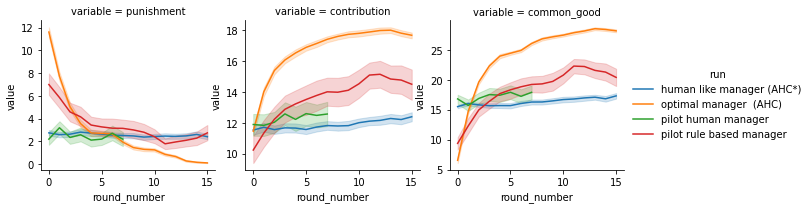

In [ ]:
w = dfm['run'].isin([
    'ah all managed by optimal',
    'ah human managed managed by humanlike',
    'pilot human manager',
    'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah all managed by optimal': 'optimal manager  (AHC)',
    'ah human managed managed by humanlike': 'human like manager (AHC*)',
    'pilot human manager': 'pilot human manager',
    'pilot rule based manager': 'pilot rule based manager'
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))


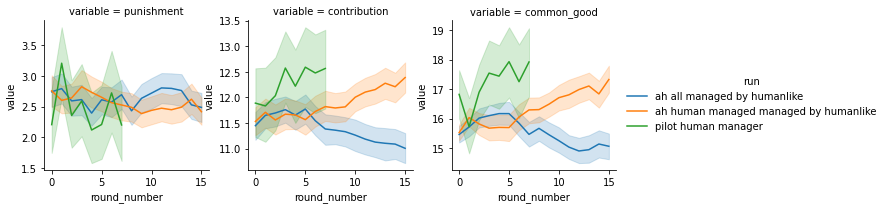

In [ ]:
w = dfm['run'].isin([
    'ah human managed managed by humanlike',
    'ah all managed by humanlike',
    'pilot human manager',
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_hm.jpg'))

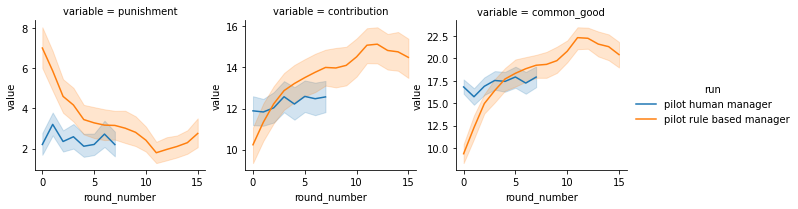

In [ ]:

w = dfm['run'].isin([
    'ah all managed managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_om.jpg'))

ah all managed by humanlike vs. pilot human manager: Mann-Whitney-Wilcoxon test two-sided, P_val:9.470e-02 U_stat=2.001e+05
ah human managed managed by humanlike vs. pilot human manager: Mann-Whitney-Wilcoxon test two-sided, P_val:4.436e-02 U_stat=1.971e+05


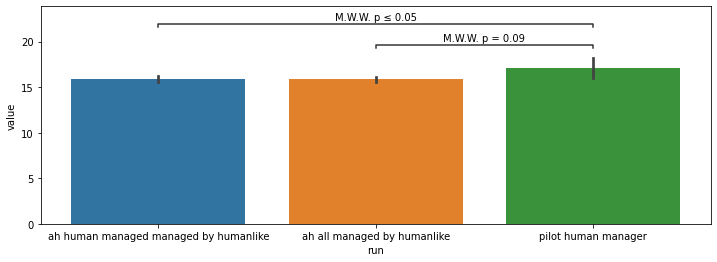

In [ ]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

order = ['ah human managed managed by humanlike', 'ah all managed by humanlike', 'pilot human manager']

w = (
    (dfm['round_number'] < 8) &
    (dfm['variable'] == 'common_good') &
    (dfm['run'].isin(order))
)

dfg = dfm[w].groupby(['participant_code', 'run', 'variable'])["value"].mean().reset_index()

pairs = [[order[0], order[2]], [order[1], order[2]]]

plt.figure(figsize=(12,4))

ax = sns.barplot(
    data=dfg,
    order=order,
    x="run", 
    y="value")

annotator = Annotator(ax, pairs, data=dfg, x='run', y='value', order=order)
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside')
annotator.apply_and_annotate()

plt.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))


In [ ]:
df

,episode,round_number,participant_code,punishment,common_good,contribution,run,global_group_id
0,ah all managed by humanlike__0,0,0_0,0.0,17.50,4.0,ah all managed by humanlike,NaN
1,ah all managed by humanlike__0,0,1_0,10.0,17.50,15.0,ah all managed by humanlike,NaN
2,ah all managed by humanlike__0,0,2_0,0.0,17.50,20.0,ah all managed by humanlike,NaN
3,ah all managed by humanlike__0,0,3_0,0.0,17.50,11.0,ah all managed by humanlike,NaN
4,ah all managed by humanlike__0,1,0_0,0.0,8.85,10.0,ah all managed by humanlike,NaN
...,...,...,...,...,...,...,...,...
197839,pilot rule based manager__d81skd2r #7,15,kc4vb44t,5.0,18.75,15.0,pilot rule based manager,d81skd2r #7
197840,pilot rule based manager__d81skd2r #8,15,abexrrr2,4.0,-4.00,7.0,pilot rule based manager,d81skd2r #8
197841,pilot rule based manager__d81skd2r #10,15,pkqvc8tk,0.0,10.75,20.0,pilot rule based manager,d81skd2r #10
197842,pilot rule based manager__d81skd2r #10,15,xw5jeu6y,30.0,10.75,0.0,pilot rule based manager,d81skd2r #10


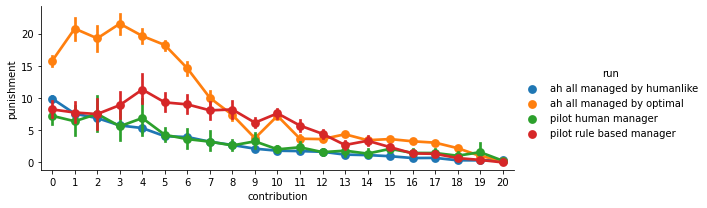

In [ ]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah all managed by humanlike',
    'ah all managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])


g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

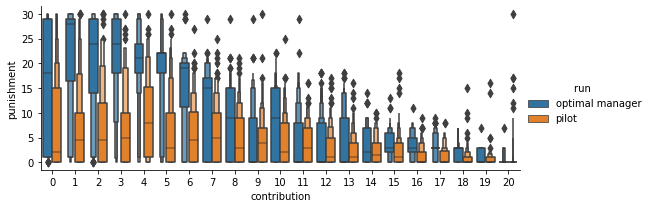

In [ ]:
df['contribution'] = df['contribution'].astype(int)

df['run '] = df['run']
df['run '] = df['run'].map({
    'pilot human manager': 'pilot',
    'pilot rule based manager': 'pilot',
    'ah all managed by optimal': 'optimal manager'
})

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run ',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))

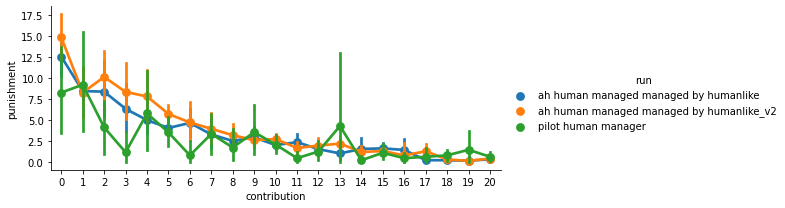

In [ ]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',    
    'pilot human manager',
]) & (df['round_number'] == 0))

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

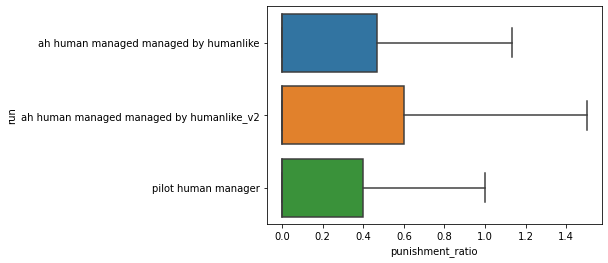

In [ ]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',
    'pilot human manager',
]) & (df['round_number'] == 0))

df['punishment_ratio'] = df['punishment'] / (20 - df['contribution'])

g = sns.boxplot(
    data=df[w],
    x="punishment_ratio", 
    y='run',
    showfliers=False,
)

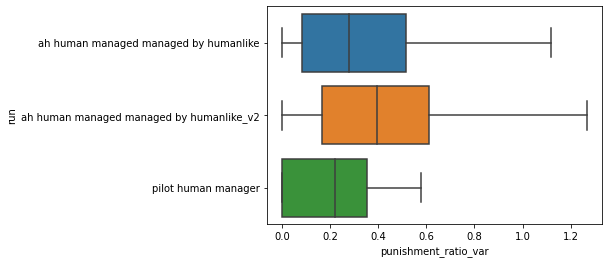

In [ ]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',
    'pilot human manager',
]) & (df['round_number'] == 0))


dfs = df[w].copy()
dfs['punishment_ratio'] = dfs['punishment'] / (20 - dfs['contribution'])
dfs['punishment_ratio_std'] = dfs.groupby(['episode'])['punishment_ratio'].transform('std')

g = sns.boxplot(
    data=dfs,
    x="punishment_ratio_var", 
    y='run',
    showfliers=False,
)


<AxesSubplot:ylabel='Density'>

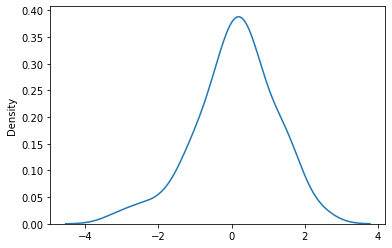

In [ ]:
weights = mm.managers['humanlike_v2'].model.x_encoder.encoder[4].map.weight[:,0].detach().numpy()

sns.kdeplot(weights)